In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

mixed_precision.set_global_policy("mixed_float16")
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

BATCH_SIZE = 16            
IMG_SIZE = (256, 256)
NUM_CLASSES = 4
TRAIN_DIR = "./archive/brisc2025/classification_task/train"
TEST_DIR  = "./archive/brisc2025/classification_task/test"
VAL_SPLIT = 0.20
STAGE1_EPOCHS = 12
STAGE2_EPOCHS = 30
FINAL_MODEL_PATH = "EfficientNetB0_BRISC_fixed.keras"   

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.12,
    brightness_range=[0.85, 1.15],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VAL_SPLIT
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=SEED,
    color_mode='rgb'
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
    seed=SEED,
    color_mode='rgb'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False

x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

model = models.Model(inputs=base.input, outputs=outputs)

opt1 = Adam(learning_rate=3e-4)
model.compile(optimizer=opt1, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()

callbacks_stage1 = [
    EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=3, min_lr=1e-6)
]

history_stage1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=STAGE1_EPOCHS,
    callbacks=callbacks_stage1
)

UNFREEZE_FROM = -120  
for layer in base.layers[UNFREEZE_FROM:]:
    layer.trainable = True

opt_finetune = Adam(learning_rate=3e-5)
model.compile(optimizer=opt_finetune, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

callbacks_stage2 = [
    EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=4, min_lr=1e-7)
]

history_stage2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=STAGE2_EPOCHS,
    callbacks=callbacks_stage2
)

model.save(FINAL_MODEL_PATH)
print(f"Saved model to {FINAL_MODEL_PATH}")

Found 3402 images belonging to 4 classes.
Found 849 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 256, 256,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 256, 256,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 4,839,847 (18.46 MB)

 Trainable params: 789,252 (3.01 MB)

 Non-trainable params: 4,050,595 (15.45 MB)

Epoch 1/12
213/213 ━━━━━━━━━━━━━━━━━━━━ 85s 306ms/step - accuracy: 0.7369 - auc: 0.9265 - loss: 0.7487 - val_accuracy: 0.8115 - val_auc: 0.9490 - val_loss: 0.6105 - learning_rate: 3.0000e-04
Epoch 2/12
213/213 ━━━━━━━━━━━━━━━━━━━━ 35s 166ms/step - accuracy: 0.8401 - auc: 0.9679 - loss: 0.4974 - val_accuracy: 0.8398 - val_auc: 0.9603 - val_loss: 0.5617 - learning_rate: 3.0000e-04
Epoch 3/12
213/213 ━━━━━━━━━━━━━━━━━━━━ 31s 144ms/step - accuracy: 0.8448 - auc: 0.9726 - loss: 0.4678 - val_accuracy: 0.8363 - val_auc: 0.9597 - val_loss: 0.6031 - learning_rate: 3.0000e-04
Epoch 4/12
213/213 ━━━━━━━━━━━━━━━━━━━━ 30s 140ms/step - accuracy: 0.8748 - auc: 0.9791 - loss: 0.4085 - val_accuracy: 0.8445 - val_auc: 0.9605 - val_loss: 0.5989 - learning_rate: 3.0000e-04
Epoch 5/12
213/213 ━━━━━━━━━━━━━━━━━━━━ 31s 148ms/step - accuracy: 0.8774 - auc: 0.9802 - loss: 0.3959 - val_accuracy: 0.8516 - val_auc: 0.9670 - val_loss: 0.5375 - learning_rate: 3.0000e-04
Epoch 6/12
213/213 ━━━━━━━━━━━━━━━━━━━━ 31s 1

2025-12-02 12:14:27.295951: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15708', 8 bytes spill stores, 8 bytes spill loads



213/213 ━━━━━━━━━━━━━━━━━━━━ 103s 291ms/step - accuracy: 0.8051 - auc: 0.9513 - loss: 0.6503 - val_accuracy: 0.8127 - val_auc: 0.9491 - val_loss: 0.7526 - learning_rate: 3.0000e-05
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - accuracy: 0.8704 - auc: 0.9789 - loss: 0.4182 - val_accuracy: 0.8327 - val_auc: 0.9610 - val_loss: 0.6561 - learning_rate: 3.0000e-05
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 34s 160ms/step - accuracy: 0.8915 - auc: 0.9820 - loss: 0.3870 - val_accuracy: 0.8528 - val_auc: 0.9661 - val_loss: 0.5679 - learning_rate: 3.0000e-05
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 36s 171ms/step - accuracy: 0.9186 - auc: 0.9907 - loss: 0.2934 - val_accuracy: 0.8551 - val_auc: 0.9622 - val_loss: 0.6232 - learning_rate: 3.0000e-05
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 33s 156ms/step - accuracy: 0.9233 - auc: 0.9907 - loss: 0.2885 - val_accuracy: 0.8681 - val_auc: 0.9690 - val_loss: 0.5478 - learning_rate: 3.0000e-05
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 30s 140ms/step 

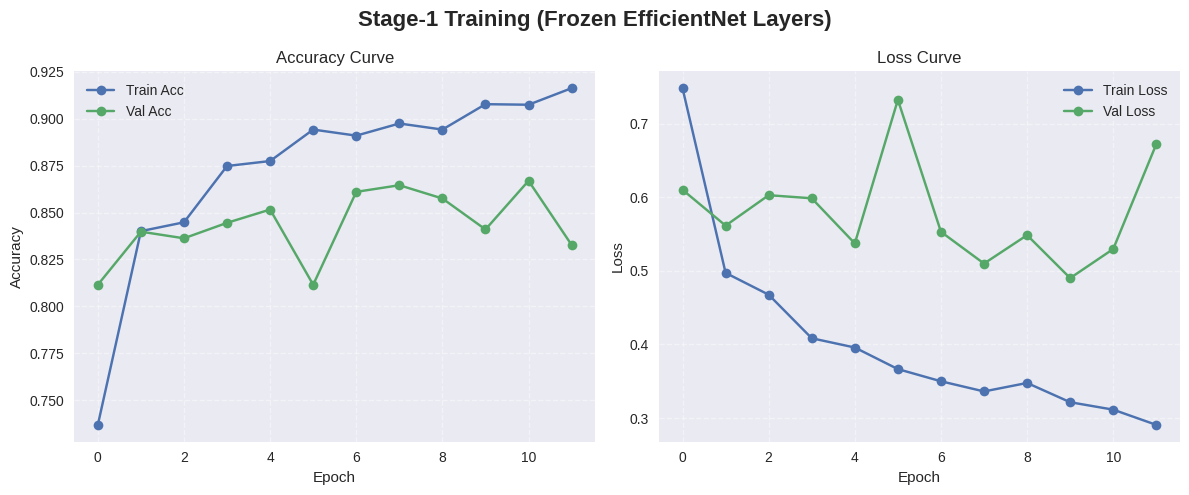

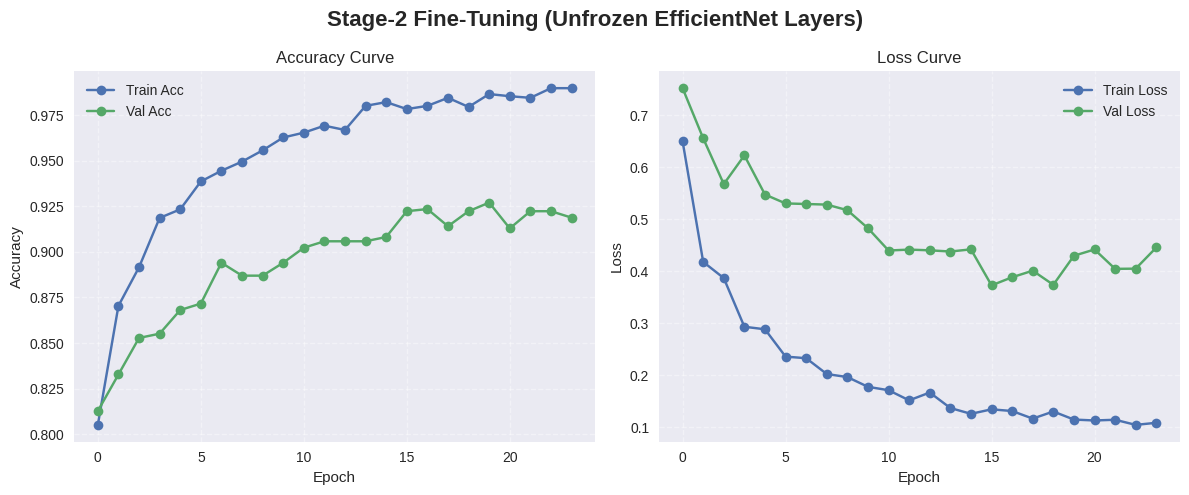

In [11]:
def plot_history(history, title):
    plt.figure(figsize=(12,5))
    plt.suptitle(title, fontsize=16, fontweight='bold')

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], marker='o', label='Train Acc')
    plt.plot(history.history['val_accuracy'], marker='o', label='Val Acc')
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], marker='o', label='Train Loss')
    plt.plot(history.history['val_loss'], marker='o', label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Stage-1 Plot
plot_history(history_stage1, "Stage-1 Training (Frozen EfficientNet Layers)")

# Stage-2 Plot
plot_history(history_stage2, "Stage-2 Fine-Tuning (Unfrozen EfficientNet Layers)")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


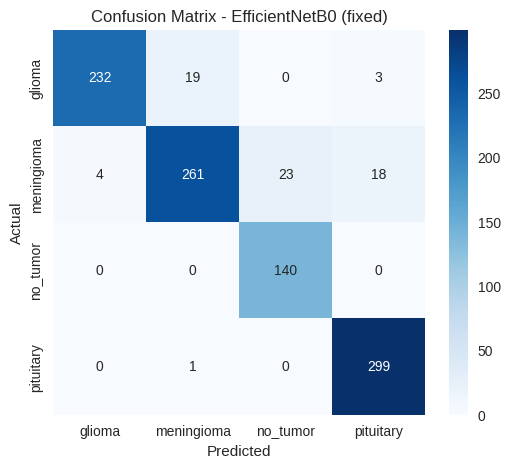


Classification Report:

              precision    recall  f1-score   support

      glioma       0.98      0.91      0.95       254
  meningioma       0.93      0.85      0.89       306
    no_tumor       0.86      1.00      0.92       140
   pituitary       0.93      1.00      0.96       300

    accuracy                           0.93      1000
   macro avg       0.93      0.94      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [12]:
test_gen.reset()
y_prob = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - EfficientNetB0 (fixed)")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))